In [1]:
import numpy as np
import glob
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
from help_func import plot, draw_lines_from_points

# Undistort

In [2]:
# initialize array for object points with dimensions (6*9, 3)
objp = np.zeros((6*9,3), np.float32)
# create mesh grid, transpose and reshape to get an (6*9, 2) array 
# for all object points (z component is assumed to be 0)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# initialize arrays for object- and image points from all
# calibration images
objpts = [] # 3D points in real world space
imgpts = [] # 2D points in image plane

In [3]:
# get list of all available calibration images
cal_images = glob.glob('camera_cal/calibration*.jpg')

In [4]:
# find chessboard corners in all images
for idx, img_name in enumerate(cal_images):
    img = cv2.imread(img_name) # read image
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # convert to grayscale
    
    # find chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)
    
    # if corners were found, object- and image points are added
    if ret == True:
        objpts.append(objp)
        imgpts.append(corners)

        # draw and display/save corners
#         cv2.drawChessboardCorners(img, (9,6), corners, ret)        
#         folder_name = 'output_images/'
#        # file_name = 'chessboard_corners_'+img_name[11:]
#        # cv2.imwrite(folder_name+file_name, img)
        # cv2.imshow('img', img)
        # cv2.waitKey(500)

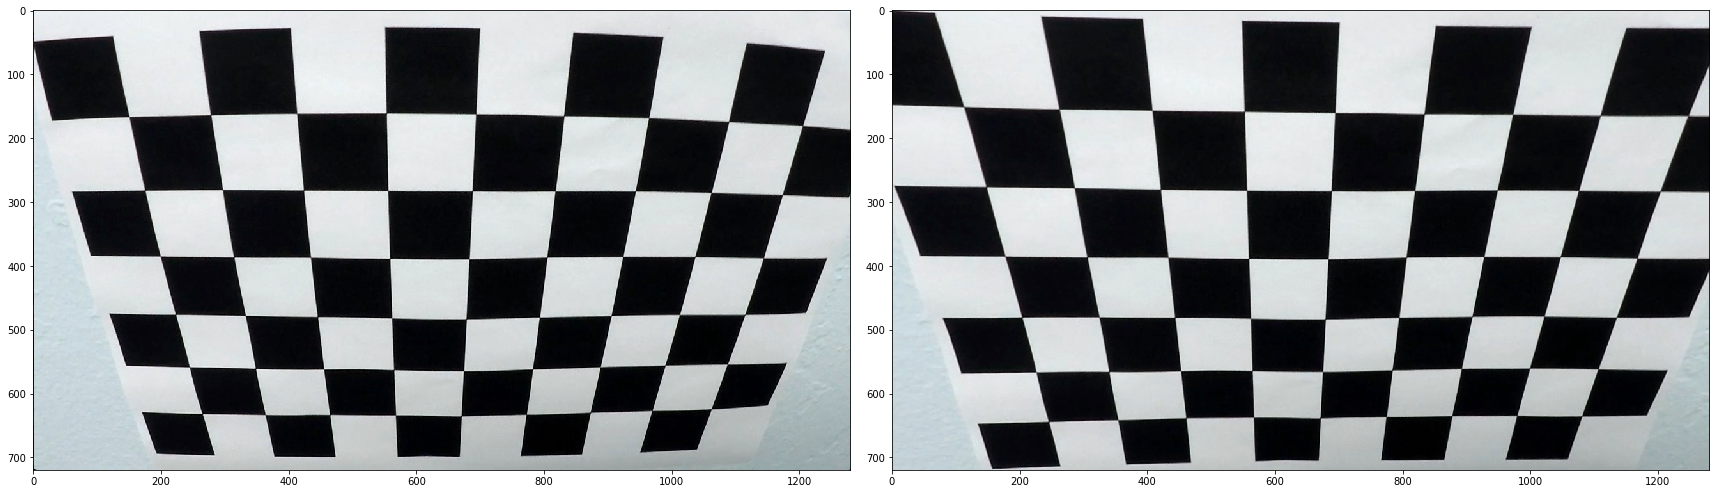

In [5]:
# load distorted image and get size
dist_img = cv2.imread('camera_cal/calibration2.jpg')
img_size = (img.shape[1], img.shape[0])

# calibrate camera (returns the camera matrix, distortion 
# coefficients, rotation and translation vectors)
ret, mtx, dist_coeff, rvecs, tvecs = cv2.calibrateCamera(
    objpts, imgpts, img_size, None ,None)

undist_img = cv2.undistort(dist_img, mtx, dist_coeff)

# undistort example image
# undist = cv2.undistort(dist_img, mtx, dist_coeff, None, mtx)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(dist_img)
ax2.imshow(undist_img)

# plt.imshow(undist_img)
# cv2.imwrite('output_images/calibration2_undistorted.jpg', undist)

# Perspective transform

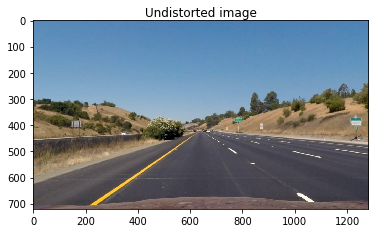

In [7]:
raw_img = mpimg.imread('test_images/straight_lines1.jpg')
img_size = (raw_img.shape[1], raw_img.shape[0])

undist_img = cv2.undistort(raw_img, mtx, dist_coeff)

# for zooming in
# %matplotlib notebook
%matplotlib inline
plt.figure()
plt.imshow(undist_img)
plt.title('Undistorted image')

In [8]:
# source points manually determined from test image 
# "straight_lines1.jpg"
src_pts = np.array([[580, 460], 
                    [700, 460], 
                    [1100, img_size[1]], 
                    [200, img_size[1]]],
                   np.float32).reshape((4, 1, 2))

# src_pts = np.array([[560, 475], 
#                     [725, 475], 
#                     [1100, img_size[1]], 
#                     [200, img_size[1]]], 
#                    np.float32).reshape((4, 1, 2))

# src_pts = np.array([[595, 450], 
#                     [685, 450], 
#                     [1100, img_size[1]], 
#                     [200, img_size[1]]], 
#                    np.float32).reshape((4, 1, 2))

In [9]:
# destination points for perspective transformation
lane_dist = 700 # in pixels
mid_pnt = img_size[0]//2
dst_pts = np.array([[mid_pnt - lane_dist/2, 0], 
                    [mid_pnt + lane_dist/2, 0], 
                    [mid_pnt + lane_dist/2, img_size[1]],
                    [mid_pnt - lane_dist/2, img_size[1]]], 
                   np.float32).reshape((4, 1, 2))

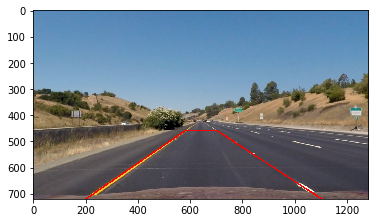

In [10]:
undist_img_cp = np.copy(undist_img)
draw_lines_from_points(undist_img_cp, src_pts)
plot(undist_img_cp)

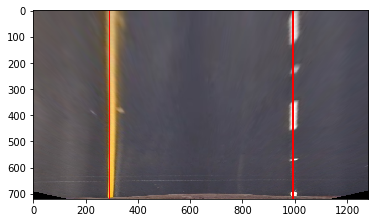

In [13]:
# perspective transform
warp_mtx = cv2.getPerspectiveTransform(src_pts, dst_pts)
warped_img = cv2.warpPerspective(undist_img, M, 
                                 img_size, flags=cv2.INTER_LINEAR)

draw_lines_from_points(warped_img, dst_pts)
plot(warped_img)

# Pickle data

In [14]:
pickle.dump({"mtx": mtx, "dist_coeff": dist_coeff, "warp_mtx": warp_mtx}, open("pickled_calib_data.p", "wb"))